# Práctica 1 - Juego de coordinación multi-acción (JCMA)

## Introducción

En esta práctica trabajaremos con un juego estático y simétrico en estrategias, donde dos jugadores eligen simultáneamente un número entero en el conjunto $S = \{0,1,2,3,4,5\}$. Si la suma de ambas elecciones no supera un umbral (5), cada jugador obtiene exactamente lo que ha pedido; si lo supera, ambos reciben 0. Este juego presenta múltiples equilibrios puros que maximizan el bienestar social, pero con distintos grados de equidad entre jugadores. Las estrategias son simétricas, en el sentido de que ambos jugadores comparten el mismo conjunto de acciones. Los resultados cuya suma es 5 son eficientes (maximizan la suma de pagos), pero reparten beneficios de forma desigual.

Más abajo encontrarás su definición formal y su matriz de pagos en forma normal, que usaremos como base para el análisis y la implementación.

## Descripción de la práctica

**¡Importante!** Revisa el juego de [Nicky Case](https://ncase.me/trust/) llamado *The Evolution of Trust* (~30min). Aunque originalmente sobre el Dilema del Prisionero Iterado (DPI), sus conceptos sobre cooperación, estrategias reactivas y dinámicas evolutivas son directamente aplicables a nuestro juego de suma limitada iterado. 

En nuestro caso, el juego es simultáneo y repetido: en cada ronda, los jugadores eligen acciones sin conocer la del rival, pero con acceso al historial completo de interacciones pasadas. Esto introduce complejidades como coordinación implícita, retaliación y evolución de normas sociales, haciendo de este juego un "dilema más complejo" que el DPI clásico (más acciones, umbral de suma, y payoffs asimétricos en equidad).

La práctica tiene dos partes:
 - Parte 1: Montar la estructura computacional que permita simular torneos del juego de suma limitada iterado.
 - Parte 2: Diseñar una estrategia para un torneo de tres fases (enfrentamiento directo, evolutivo, y en ecosistema ampliado).

## Definición formal del JCMA

- Jugadores: P1, P2.
- Acciones posibles: $S = \{0,1,2,3,4,5\}$.
- Funciones de pago: sea $i$ la acción escogida por el jugador P1 y $j$ la acción escogida por el jugador P2, se define $u_1$ y $u_2$ como los pagos que obtiene el jugador P1 y P2 respectivamente:

$$
 u_1(i,j)=\begin{cases}
 i, & \text{si } i+j\le 5,\\
 0, & \text{si } i+j>5,
 \end{cases}
 \qquad
 u_2(i,j)=\begin{cases}
 j, & \text{si } i+j\le 5,\\
 0, & \text{si } i+j>5.
 \end{cases}
$$

Es decir cada jugador obtiene *"lo que pide"*, a no ser que la suma de lo que todos piden sea mayor que 5, en cuyo caso nadie gana nada.



## Matriz de pagos

Por filas la acción del jugador P1, por columnas la acción del jugador P2.

<center>

|   i\j |     0 |     1 |     2 |     3 |         4 |         5 |
| ----: | ----: | ----: | ----: | ----: | --------: | --------: |
| **0** | (0,0) | (0,1) | (0,2) | (0,3) |   (0,4)   |   (0,5)   |
| **1** | (1,0) | (1,1) | (1,2) | (1,3) |   (1,4)   |   (0,0)   |
| **2** | (2,0) | (2,1) | (2,2) | (2,3) |   (0,0)   |   (0,0)   |
| **3** | (3,0) | (3,1) | (3,2) | (0,0) |   (0,0)   |   (0,0)   |
| **4** | (4,0) | (4,1) | (0,0) | (0,0) |   (0,0)   |   (0,0)   |
| **5** | (5,0) | (0,0) | (0,0) | (0,0) |   (0,0)   |   (0,0)   |


</center>


## Parte 1: Software para el estudio del JCMA

El primer objetivo es crear un software que permita simular torneos del juego definido arriba en las versiones "enfrentamiento directo" y  "evolutiva".

Requisitos mínimos:

- Programado en Python >3.8, utilizando programación orientada a objetos (OOP).
- Entradas para el torneo de enfrentamiento directo:
  - `all_players`: lista o tupla de jugadores participantes (con su estrategia).
  - `game`: objeto que define el juego (conjunto de acciones S={0..5}, umbral T=5 y función de pagos u1,u2).
  - `repetitions`: número de veces que una estrategia se enfrenta a otra.
  - `noise` (opcional): probabilidad de ejecución errónea de la acción elegida.
- Salidas: información (visual) del resultado del campeonato (ranking y puntuaciones agregadas).
- Incluir al menos estrategias básicas: `AlwaysK` para K∈{0,1,2,3,4,5} y `UniformRandom`. Debe ser sencillo añadir nuevas estrategias.

Estructura de proyecto recomendada (solo si piensas trabajar en local, si usas este notebook como lugar de trabajo, ignórala):

```
.
└── limited_sum/
    ├── limited_sum/
    │   ├── __init__.py
    │   ├── game.py        # define S, T y la función de pagos u1,u2
    │   ├── player.py      # clase base Player y estrategias básicas (AlwaysK, Random)
    │   ├── match.py       # partida one-shot entre dos jugadores y registro de payoffs
    │   ├── tournament.py  # lógica del torneo todos-contra-todos
    │   └── evolution.py   # dinámica evolutiva
    ├── main.py
    └── ...
```

### Plantilla de desarrollo

A continuación se propone una **plantilla de desarrollo** con los módulos/clases que se recomienda implementar para resolver este problema. No es obligatorio seguir esta estructura, pero a falta de mejores ideas, puede ser un buen punto de partida.

Para facilitar la tarea de identificar qué métodos faltan por implementar, en todos ellos se ha incluido la excepción ```raise NotImplementedError``` para poner de manifiesto que dicho método debe ser implementado.

El uso de librerías **basicas** está permitido, siempre que esté justificado.


In [16]:
from abc import ABC, abstractmethod
import numpy as np
import copy
import math
import matplotlib.pyplot as plt
import itertools
import random

from typing import Self, Sequence


#### El módulo ```game```

El primer módulo que se recomienda implementar es el que recoge la información sobre el juego. Como nuestro juego tiene 6 acciones posibles (0 a 5), por simplicidad crearemos constantes para representarlas. El umbral de suma es THRESHOLD=5. Representarán estas acciones a lo largo de todo el código:

In [17]:
# Acciones del juego de suma limitada
ACTIONS = (0, 1, 2, 3, 4, 5)
THRESHOLD = 5  # Umbral de suma

Ahora se propone implementar una clase llamada ```Game``` para representar el juego de suma limitada.

In [18]:
class Game:

    def __init__(self, actions: Sequence[int] = ACTIONS, threshold: int = THRESHOLD):
        """
        Represents the limited-sum game.

        Parameters:
            - actions (list[int]): list of possible actions (default: [0,1,2,3,4,5])
            - threshold (int): sum threshold beyond which both get 0 (default: 5)
        """
        self.actions = actions
        self.threshold = threshold

    @property
    @abstractmethod
    def payoff_matrix(self) -> np.ndarray:
        """
        Payoff matrix of the game.

        Returns:
            - 6x6 np array of the matrix
        """
        N = len(self.actions)
        
        matrix = np.empty((N, N), dtype=object)

        for i in range(N):
            for j in range(N):
                if i + j <= self.threshold:
                    matrix[i, j] = (i, j)
                else:
                    matrix[i, j] = (0, 0)
        
        return matrix   


    @abstractmethod
    def evaluate_result(self, a_1: int, a_2: int) -> tuple[float, float]:
        """
        Given two actions, returns the payoffs of the two players.

        Parameters:
            - a_1 (int): action of player 1 (0 to 5)
            - a_2 (int): action of player 2 (0 to 5)

        Returns:
            - tuple of two floats, being the first and second values the payoff
            for the first and second player, respectively.
        """
        payoff = self.payoff_matrix
        return payoff[a_1, a_2]


Comprueba que los métodos anteriores funcionan correctamente con el siguiente test:

In [19]:
# Prints all possible outcomes of the limited-sum game
game = Game(actions=ACTIONS, threshold=THRESHOLD)
possible_actions = ACTIONS
for a1, a2 in itertools.product(possible_actions, repeat=2):
    print(f"{(a1, a2)} -> {game.evaluate_result(a1, a2)}")

# Output:
# (0, 0) -> (0, 0)
# (0, 1) -> (0, 1)
# ...
# (5, 5) -> (0, 0)

(0, 0) -> (0, 0)
(0, 1) -> (0, 1)
(0, 2) -> (0, 2)
(0, 3) -> (0, 3)
(0, 4) -> (0, 4)
(0, 5) -> (0, 5)
(1, 0) -> (1, 0)
(1, 1) -> (1, 1)
(1, 2) -> (1, 2)
(1, 3) -> (1, 3)
(1, 4) -> (1, 4)
(1, 5) -> (0, 0)
(2, 0) -> (2, 0)
(2, 1) -> (2, 1)
(2, 2) -> (2, 2)
(2, 3) -> (2, 3)
(2, 4) -> (0, 0)
(2, 5) -> (0, 0)
(3, 0) -> (3, 0)
(3, 1) -> (3, 1)
(3, 2) -> (3, 2)
(3, 3) -> (0, 0)
(3, 4) -> (0, 0)
(3, 5) -> (0, 0)
(4, 0) -> (4, 0)
(4, 1) -> (4, 1)
(4, 2) -> (0, 0)
(4, 3) -> (0, 0)
(4, 4) -> (0, 0)
(4, 5) -> (0, 0)
(5, 0) -> (5, 0)
(5, 1) -> (0, 0)
(5, 2) -> (0, 0)
(5, 3) -> (0, 0)
(5, 4) -> (0, 0)
(5, 5) -> (0, 0)


#### El módulo ```player```

Ahora vamos a programar un módulo que sirva para representar a los jugadores. En particular, su método principal será ```strategy()```, que devolverá una acción a realizar, en base a la historia de interacción con otro jugador. Además, aprovecharemos a implementar estrategias básicas, para que luego sea sencillo hacer pruebas. Algunas de estas estrategias tienen soluciones abiertas: por el momento, implementa lógicas sencillas, ya que estas estrategias se usarán para testeo exclusivamente.

Empezaremos programando una clase abstracta llamada ```Player``` de la que heredarán los jugadores concretos que programaremos a continuación.

In [20]:
class Player(ABC):

    # Este método ya está implementado
    @abstractmethod
    def __init__(self, game: Game, name: str = ""):
        """
        Abstract class that represents a generic player

        Parameters:
            - name (str): the name of the strategy
            - game (Game): the game that this player will play
        """

        self.name = name
        self.game = game

        self.history  = []  # This is the main variable of this class. It is
                            # intended to store all the history of actions
                            # performed by this player.
                            # Example: [0, 1, 2, 3] <- So far, the
                            # interaction lasts four rounds. In the first one,
                            # this player chose 0. In the second, 1. Etc.


    # Este método ya está implementado
    @abstractmethod
    def strategy(self, opponent: Self) -> int:
        """
        Main call of the class. Gives the action for the following round of the
        interaction, based on the history

        Parameters:
            - opponent (Player): is another instance of Player.

        Results:
            - An integer representing the action (0 to 5)
        """
        pass


    def compute_scores(self, opponent: Self) -> tuple[float, float]:
        """
        Compute the scores for a given opponent

        Parameters:
            - opponent (Player): is another instance of Player.

        Results:
            - A tuple of two floats, where the first value is the current
            player's payoff, and the second value is the opponent's payoff.
        """
        total_payoff = (0.0 , 0.0)

        for i, move in enumerate(self.history):
            current_payoff = self.game.evaluate_result(move, opponent.history[i])
            total_payoff = np.add(np.array(total_payoff), np.array(current_payoff)).tolist()
            
        return total_payoff

    # Este método ya está implementado
    def clean_history(self):
        """Resets the history of the current player"""
        self.history = []


# A continuación se representan las estrategias básicas para el juego de suma limitada

class Always0(Player):

    def __init__(self, game: Game, name: str = ""):
        """Always chooses 0"""
        super().__init__(game=game, name=name)

    def strategy(self, opponent: Player) -> int:
        """Always chooses 0"""
        return 0

class Always3(Player):

    def __init__(self, game: Game, name: str = ""):
        """Always chooses 3"""
        super().__init__(game=game, name=name)


    def strategy(self, opponent: Player) -> int:
        """Always chooses 3"""
        return 3

class UniformRandom(Player):

    def __init__(self, game: Game, name: str = ""):
        """Chooses uniformly at random"""
        super().__init__(game=game, name=name)

    def strategy(self, opponent: Player) -> int:
        """Chooses uniformly at random"""
        return random.randint(0,5)

class Focal5(Player):

    def __init__(self, game: Game, name: str = ""):
        """Tries to coordinate on i+j=5. Several logics possible."""
        super().__init__(game=game, name=name)


    def strategy(self, opponent: Player) -> int:
        """First round: 2, then adapts based on opponent trying to maximize the
        chances of establishing a 5-way split in each round."""
        if(len(self.history) == 0):
            move = 2
        else:
            move = 5 - opponent.history[-1]

        return move

class TitForTat(Player):

    def __init__(self, game: Game, name: str = ""):
        """Tit-for-tat adapted to the JCMA. Several logics possible."""
        super().__init__(game=game, name=name)


    def strategy(self, opponent: Player) -> int:
        """Similar to Focal5, but reactive with opponent's actions above 3."""
        move = 2 # Si es el primer movimiento
        if(len(self.history) > 0):
            if(opponent.history[-1] > 3):
                move = opponent.history[-1]
            else:
                move = 2       
        return move

Testearemos este módulo una vez programemos el siguiente

#### El módulo ```match```

Ya sabemos manejar jugadores. Ahora vamos a enfrentarles. El presente módulo pretende recoger las herramientas necesarias para enfrentar a dos jugadores en una *partida* del JCMA. Está compuesto por una clase llamada ```Match``` que implementa el método principal ```play()```. Incluye el mecanismo de *"error"*: aleatoriamente para cada jugador y ronda, con una cierta probabilidad `error`, la acción del jugador $a$ será cambiada por su complementaria:
 - 0 ↔ 5
 - 1 ↔ 4
 - 2 ↔ 3
 - 3 ↔ 2
 - 4 ↔ 1
 - 5 ↔ 1

In [21]:
class Match:

    # Este método ya está implementado
    def __init__(self, player_1: Player,
                       player_2: Player,
                       n_rounds: int = 100,
                       error: float = 0.0):
        """
        Match class to represent an iterative limited-sum game

        Parameters:
            - player_1 (Player): first player of the match
            - player_2 (Player): second player of the match
            - n_rounds (int = 100): number of rounds in the match
            - error (float = 0.0): error probability (on a 0-1 scale).
        """

        assert n_rounds > 0, "'n_rounds' should be greater than 0"

        self.player_1 = player_1
        self.player_2 = player_2
        self.n_rounds = n_rounds
        self.error = error

        self.score = (0.0, 0.0)  # this variable will store the final result of
                                 # the match, once the 'play()' function has
                                 # been called. The two values of the tuple
                                 # correspond to the points scored by the first
                                 # and second player, respectively.


    def complement_action(self, action: int) -> int:
        """
        Return the complementary action for error mechanism

        Parameters
            - action (int): The action on which the complementary
            operation will be calculated.
        """
        complement = {0:5, 1:4, 2:3, 3:2, 4:1, 5:0}
        return complement[action]

    
    def play(self, do_print: bool = False) -> None:
        """
        Main call of the class. Play the match.
        Stores the final result in 'self.score'

        Parameters
            - do_print (bool = False): if True, should print the ongoing
            results at the end of each round (i.e. print round number, last
            actions of both players and ongoing score).
        """
        if do_print:
            print("##############################")
            print(f"PARTIDO {self.player_1.name} VS {self.player_2.name}")
            print("##############################")

        self.player_1.clean_history()
        self.player_2.clean_history()
        
        for i in range(self.n_rounds):
            r1 = self.player_1.strategy(self.player_2)
            r2 = self.player_2.strategy(self.player_1)

            if random.random() < self.error:
                r1 = self.complement_action(r1)
            if random.random() < self.error:
                r2 = self.complement_action(r2)

            self.player_1.history.append(r1)
            self.player_2.history.append(r2)

            payoff = self.player_1.game.evaluate_result(r1, r2)

            self.score = (self.score[0] + payoff[0], self.score[1] + payoff[1])

            if do_print:
                print(f" >>> ROUND {i+1}")    
                print("Player 1 action:", r1)
                print("Player 2 action:", r2)
                print("Round payoff:", payoff)
                print("Acumulated total score:", self.score)

            

Comprueba que los últimos dos módulos funcionan como se espera en la siguiente celda. Experimenta con distintas combinaciones de jugadores y observa que los resultados son los esperados. Por ejemplo, un Always0 y un Focal5 deberían coordinarse en (0,5) tras la primera ronda, obteniendo 0 y 5 puntos respectivamente por ronda. Comprueba también que el error se está tratando como corresponde. Por ejemplo, fíjalo en un valor alto (e.g. 0.2) y observa cómo las acciones pueden cambiar aleatoriamente. Comprueba también que puedes enfrentar dos jugadores que jueguen la misma estrategia (simplemente crea dos instancias del mismo jugador, con distintos nombres).

In [ ]:
game = Game()

always0_player = Always0(game, "always0")
always3_player = Always3(game, "always3")
random_player = UniformRandom(game, "random")
focal5_player = Focal5(game, "focal5")
tft_player = TitForTat(game, "tft")

match = Match(always0_player, focal5_player, n_rounds=10, error=0.0)
match.play(do_print=True)

match2 = Match(always3_player, Always3(game, "always3_2"), n_rounds=8, error=0.2)
match2.play(do_print=True)

match2 = Match(random_player, tft_player, n_rounds=5, error=0.0)
match2.play(do_print=True)


##############################
PARTIDO always0 VS focal5
##############################
 >>> ROUND 1
Player 1 action: 0
Player 2 action: 2
Round payoff: (0, 2)
Acumulated total score: (0.0, 2.0)
 >>> ROUND 2
Player 1 action: 0
Player 2 action: 5
Round payoff: (0, 5)
Acumulated total score: (0.0, 7.0)
 >>> ROUND 3
Player 1 action: 0
Player 2 action: 5
Round payoff: (0, 5)
Acumulated total score: (0.0, 12.0)
 >>> ROUND 4
Player 1 action: 0
Player 2 action: 5
Round payoff: (0, 5)
Acumulated total score: (0.0, 17.0)
 >>> ROUND 5
Player 1 action: 0
Player 2 action: 5
Round payoff: (0, 5)
Acumulated total score: (0.0, 22.0)
 >>> ROUND 6
Player 1 action: 0
Player 2 action: 5
Round payoff: (0, 5)
Acumulated total score: (0.0, 27.0)
 >>> ROUND 7
Player 1 action: 0
Player 2 action: 5
Round payoff: (0, 5)
Acumulated total score: (0.0, 32.0)
 >>> ROUND 8
Player 1 action: 0
Player 2 action: 5
Round payoff: (0, 5)
Acumulated total score: (0.0, 37.0)
 >>> ROUND 9
Player 1 action: 0
Player 2 action: 5

#### El módulo ```tournament```

Finalmente, llegamos al módulo que nos va a permitir simular el campeonato. 

In [23]:
class Tournament:

    # Este método ya está implementado
    def __init__(self, players: tuple[Player, ...],
                       n_rounds: int = 100,
                       error: float = 0.0,
                       repetitions: int = 2):
        """
        All-against-all tournament

        Parameters:
            - players (tuple[Player, ...]): tuple of players that will play the
         tournament
            - n_rounds (int = 100): number of rounds in each match
            - error (float = 0.0): error probability (in base 1)
            - repetitions (int = 2): number of matches each player plays against
         each other player
        """

        self.players = players
        self.n_rounds = n_rounds
        self.error = error
        self.repetitions = repetitions

        # This is a key variable of the class. It is intended to store the
        # ongoing ranking of the tournament. It is a dictionary whose keys are
        # the players in the tournament, and its corresponding values are the
        # points obtained in their interactions with each other. In the end, to
        # see the winner, it will be enough to sort this dictionary by the
        # values.
        self.ranking = {player: 0.0 for player in self.players}  # initial vals


    def sort_ranking(self) -> None:
        """Sort the ranking by the value (score)"""
        self.ranking = dict(sorted(self.ranking.items(), key=lambda item: item[1], reverse=True))
        

    #pista: utiliza 'itertools.combinations' para hacer los cruces
    def play(self) -> None:
        """
        Main call of the class. It must simulate the championship and update
        the variable 'self.ranking' with the accumulated points obtained by
        each player in their interactions.
        """
        self.ranking = {player: 0.0 for player in self.players}

        for p1, p2 in itertools.combinations(self.players, 2):
            for _ in range(self.repetitions):
                match = Match(p1, p2, n_rounds=self.n_rounds, error=self.error)
                match.play(do_print=False)
                self.ranking[p1] += match.score[0]
                self.ranking[p2] += match.score[1]
                
        self.sort_ranking()

    def plot_results(self):
        """
        Plots a bar chart of the final ranking. On the x-axis should appear
        the names of the sorted ranking of players participating in the
        tournament. On the y-axis the points obtained.
        """
        import matplotlib.pyplot as plt

        names = [player.name for player in self.ranking.keys()]
        scores = list(self.ranking.values())
        
        plt.figure(figsize=(10,5))
        plt.bar(names, scores, color='skyblue')
        plt.xlabel("Players")
        plt.ylabel("Points")
        plt.title("Tournament ")
        plt.show()


Para testear la implementación, prueba un torneo con las estrategias básicas del juego de suma limitada. Por ejemplo, con 10 rondas por interacción y sin error. Observa cómo diferentes estrategias obtienen diferentes puntuaciones según su capacidad para coordinarse en equilibrios eficientes o explotar a rivales cooperativos.

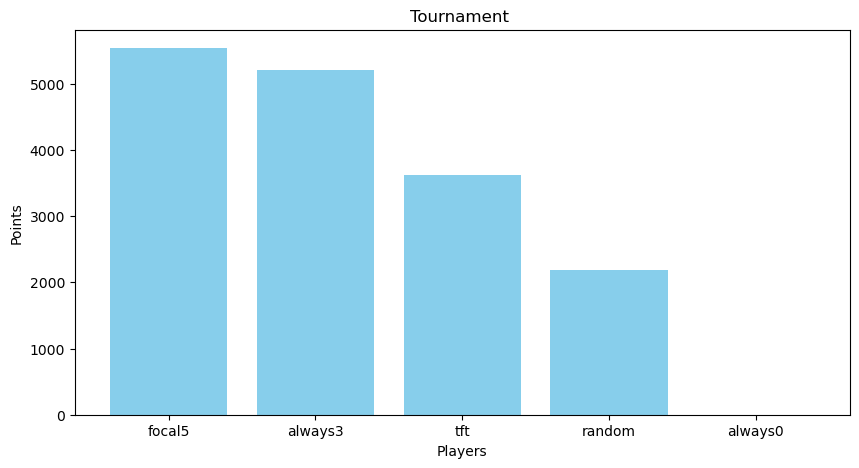

In [34]:
game = Game()

always0_player = Always0(game, "always0")
always3_player = Always3(game, "always3")
random_player = UniformRandom(game, "random")
focal5_player = Focal5(game, "focal5")
tft_player = TitForTat(game, "tft")

all_players = (always0_player, always3_player, random_player, focal5_player,
               tft_player)

tournament = Tournament(all_players, n_rounds=100, error=0.0, repetitions=5)
tournament.play()
tournament.plot_results()

#### El módulo ```evolution```

A continuación se presenta la variante evolutiva del torneo, similar a la que se explica en la sección "4. Repeated Tournament" del juego de Nicky Case. Este módulo necesitará de inputs extra. Ten en cuenta lo siguiente:
 - La población inicial de jugadores no es directamente el input de jugadores que dé el usuario, sino que cada jugador tiene varios "individuos" o "réplicas" que jugarán su estrategia. El usuario podrá definir la población inicial de dos opciones (ambos mecanismos deben ser funcionales en tu implementación):
   - Si el usuario define el tamaño de la población total (```int```), se asume que cada jugador comienza con el mismo número de representantes. Divide ese número entre el número de jugadores (redondeado al entero más próximo) y así obtendrás el número de individuos inicial de cada estrategia.
   - Si el usuario define una tupla de números de individuos (```list[int, ...]```), se asume que cada jugador tendrá el número de representantes que indique su índice dentro de dicha tupla.
 - Hay dos parámetros más que controlan el proceso evolutivo. 
   - En primer lugar, el porcentaje de individuos que se desea incluir en la selección natural tras cada ronda; esto es, el número de individuos *de la parte de abajo del ranking* que se van a eliminar y sustituir por los *individuos de la parte de arriba* (en caso de empate entre individuos, escoge al azar).
   - En segundo lugar, el número de generaciones que se van a simular. Una generación es básicamente un "Torneo de enfrentamiento directo" + un "Proceso de selección natural". 

El resto de decisiones de diseño que debas tomar son libres. A continuación se incluye la plantilla de desarrollo sugerida.

In [35]:
class Evolution:

    # Este método ya está implementado
    def __init__(self, players: tuple[Player, ...],
                       n_rounds: int = 100,
                       error: float = 0.0,
                       repetitions: int = 2,
                       generations: int = 100,
                       reproductivity: float = 0.05,
                       initial_population: tuple[int, ...] | int = 100):
        """
        Evolutionary tournament

        Parameters:
            - players (tuple[Player, ...]): tuple of players that will play the
         tournament
            - n_rounds (int = 100): number of rounds in each game
            - error (float = 0.0): error probability (in base 1)
            - repetitions (int = 2): number of games each player plays against
         the rest
            - generations (int = 100): number of generations to simulate
            - reproductivity (float = 0.05): ratio (base 1) of worst players
         that will be removed and substituted by the top ones in the natural
         selection process carried out at the end of each generation
            - initial_population (tuple[int, ...] | int = 100): list of
         individuals representing each players (same index as 'players' tuple)
         OR total population size (int).
        """

        self.players = players
        self.n_rounds = n_rounds
        self.error = error
        self.repetitions = repetitions
        self.generations = generations
        self.reproductivity = reproductivity

        if isinstance(initial_population, int):
            self.initial_population = [math.floor(initial_population
                                       / len(self.players))
                                       for _ in range(len(self.players))]
        else:
            self.initial_population = initial_population

        self.total_population = sum(self.initial_population)
        self.repr_int = int(self.total_population * self.reproductivity)

        self.ranking = {copy.deepcopy(player): 0.0 for i, player in
                        enumerate(self.players)
                        for _ in range(self.initial_population[i])}


    def natural_selection(self, result_tournament: dict[Player, float]) \
                          -> dict[Player, float]:
        """
        Kill the worst guys, reproduce the top ones. Takes the ranking once a
        face-to-face tournament has been played and returns another ranking,
        with the evolutionary changes applied

        Parameters:
            - result_tournament: the 'tournament.ranking' kind of dict.

        Results:
            - Same kind of dict ranking as the input, but with the evolutionary
         dynamics applied
        """

        # Convert to list of items (already sorted from highest to lowest score)
        sorted_players = list(result_tournament.items())
        
        # Get best and worst players
        best_players = sorted_players[:self.repr_int]
        worst_players = sorted_players[-self.repr_int:]
        
        # Create result after evolution by copying best players over worst
        result_after_evolution = dict(sorted_players)
        
        # Replace worst players with copies of best players
        for i in range(self.repr_int):
            # Remove worst player
            worst_player = worst_players[i][0]
            del result_after_evolution[worst_player]
            
            # Add a copy of best player
            best_player = best_players[i][0]
            best_player_copy = copy.deepcopy(best_player)
            best_player_copy.clean_history()
            result_after_evolution[best_player_copy] = 0.0
        
        return result_after_evolution 


    def count_strategies(self) -> dict[str, int]:
        """
        Counts the number of played alive of each strategy, based on the
        initial list of players. Should be computed analyzing the
        'self.ranking' variable. Useful for the results plot/print (not needed
        for the tournament itself)

        Results:
            - A dict, containing as values the name of the players and as
         values the number of individuals they have now alive in the tournament
        """

        count_dict = {player.name: 0 for player in self.players}
        
        for player in self.ranking.keys():
            count_dict[player.name] += 1
        
        return count_dict


    def play(self, do_print: bool = False):
        """
        Main call of the class. Performs the computations to simulate the
        evolutionary tournament.

        Parameters
            - do_print (bool = False): if True, should print the ongoing
         results at the end of each generation (i.e. print generation number,
         and number of individuals playing each strategy).
        """

        # HINT: Initialise the following variable
        #  > count_evolution = {player.name: [val] for player, val in
        #                       zip(self.players, self.initial_population)}
        # and use it to store the number of individuals each player retains at
        # the end of each generation, appending to its corresponding list value
        # the number of individuals each player has (obtained by calling
        # 'self.count_strategies()'). For example, at some point, it could have
        # the following value:
        # {'always0': [15, 10, 5, 0, 0, 0, 0, 0, 0, 0, 0],
        #  'random': [5, 10, 15, 19, 14, 9, 4, 0, 0, 0, 0],
        #  'focal5': [5, 5, 5, 6, 11, 16, 21, 25, 25, 25, 25]}

        count_evolution = {player.name: [val] for player, val in
                           zip(self.players, self.initial_population)}
        
        for gen in range(self.generations):
            tournament = Tournament(tuple(self.ranking.keys()),
                                    n_rounds=self.n_rounds,
                                    error=self.error,
                                    repetitions=self.repetitions)
            tournament.play()
            
            self.ranking = self.natural_selection(tournament.ranking)
            
            current_counts = self.count_strategies()
            for player_name, count in current_counts.items():
                count_evolution[player_name].append(count)
                
            if do_print:
                print('##############################')
                print(f"GENERATION {gen + 1}")
                print('##############################')
                for player_name, count in current_counts.items():
                    print(f"Strategy {player_name}: {count} individuals")
                print()
        
        self.stackplot(count_evolution)


    # Si quieres obtener un buen gráfico de la evolución, puedes usar este
    # método si has seguido la pista indicada en la cabecera del método
    # anterior. Ya está implementado, pero puede que necesites adaptarlo a tu
    # código.
    def stackplot(self, count_evolution: dict[str, list]) -> None:
        """
        Plots a 'stackplot' of the evolution of the tournament

        Parameters:
            - count_evolution (dict[Player, list]): a dictionary containing as
         keys the name of the strategies of the different players of the
         tournament. Each value is a list, where the 'i'-th position of that
         list indicates the number of individuals that player has at the end of
         the 'i'-th generation
         """

        COLORS = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']

        for i, name in enumerate(count_evolution.keys()):
            plt.plot([], [], label=name, color= COLORS[(i) % len(COLORS)])

        plt.stackplot(list(range(self.generations + 1)),
                      np.array(list(count_evolution.values())), colors=COLORS)

        plt.legend()
        plt.show()



Para testear el módulo anterior, puedes experimentar con diferentes poblaciones iniciales de estrategias. Por ejemplo, un torneo evolutivo con estrategias Always0, UniformRandom y Focal5, sin error, con 10 rondas por interacción, con una reproductividad del 0.2. Observa qué estrategias dominan la población a lo largo de las generaciones:

##############################
GENERATION 1
##############################
Strategy always0: 10 individuals
Strategy random: 5 individuals
Strategy focal5: 10 individuals

##############################
GENERATION 2
##############################
Strategy always0: 5 individuals
Strategy random: 5 individuals
Strategy focal5: 15 individuals

##############################
GENERATION 3
##############################
Strategy always0: 0 individuals
Strategy random: 5 individuals
Strategy focal5: 20 individuals

##############################
GENERATION 4
##############################
Strategy always0: 0 individuals
Strategy random: 4 individuals
Strategy focal5: 21 individuals

##############################
GENERATION 5
##############################
Strategy always0: 0 individuals
Strategy random: 1 individuals
Strategy focal5: 24 individuals

##############################
GENERATION 6
##############################
Strategy always0: 0 individuals
Strategy random: 0 individuals
Strate

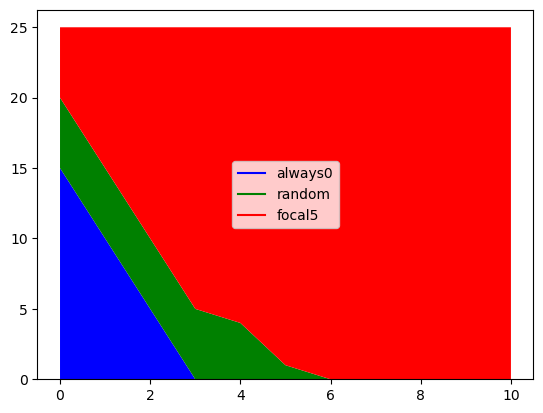

In [36]:
game = Game()

always0_player = Always0(game, "always0")
random_player = UniformRandom(game, "random")
focal5_player = Focal5(game, "focal5")

all_players = (always0_player, random_player, focal5_player)

evolution = Evolution(all_players, n_rounds=10, error=0.00,
                      repetitions=1, generations=10, reproductivity=0.2,
                      initial_population=(15, 5, 5))

evolution.play(True)

¡Enhorabuena! La primera parte de la práctica ya la has terminado. Ahora puedes experimentar todo lo que quieras con el juego de suma limitada iterado. Tú mismo has creado la herramienta para hacerlo. En la siguiente sección, tendrás que diseñar una estrategia para participar en un triple campeonato.

## Parte 2: diseño de una estrategia

A continuación deberás implementar una estrategia que se enfrentará a las de tus compañeros en un torneo del JCMA.

Los juegos contra tus rivales tendrán un final **no determinista**. Esto quiere decir que el número de rondas que se van a jugar no se sabe con precisión. En lugar de eso, después de cada ronda, la partida tiene una cierta probabilidad de acabar (pequeña). ¿Por qué haremos esto? En juegos iterados con duración finita conocida, la proximidad del final juega un papel crucial en las decisiones estratégicas (e.g., incentivos a desertar en las últimas rondas).

Con el objetivo de dejar esta complejidad adicional fuera, jugaremos un número de rondas aleatorio: puedes pensar que tu estrategia va a jugar "muchas veces" contra cada rival. **En media, se jugarán 100 rondas** (puedes quedarte con ese número). Los puntos obtenidos en cada interacción se normalizarán por el número de rondas jugadas para evitar sesgos por duración variable.

### Descripción del campeonato
Ahora sí, vamos a ver las condiciones del torneo. Hay tres fases en esta competición:
 - Fase de enfrentamiento directo entre estrategias
 - Fase evolutiva
 - Fase evolutiva dentro del ecosistema completo del juego de suma limitada


#### Fase de enfrentamiento directo entre estrategias

Se jugará un torneo de *todos contra todos*: te enfrentarás a las estrategias de tus rivales dos veces. El resultado que obtengas en cada enfrentamiento se sumará a los ya obtenidos hasta el momento. Ganará la estrategia con más puntos al final de las interacciones. Las condiciones concretas son las siguientes:
 - El JCMA que se usará será el definido anteriormente: acciones S={0,1,2,3,4,5}, umbral T=5, y payoffs u1(i,j)=i si i+j≤5, 0 si i+j>5 (análogamente para u2).
 - La probabilidad de acabar el enfrentamiento tras cada ronda $P_{end}$ se fija en 1%, con un máximo de rondas de 400.
 - La probabilidad de error $P_{error}$ se fija en 1%.
 - Se jugará 2 veces contra cada rival.

Se asignarán los siguientes puntos según la posición final:
 - 5º y 6º clasificados: 4 puntos
 - 4º clasificado: 8 puntos
 - 3º clasificado: 12 puntos
 - 2º clasificado: 17 puntos
 - 1º clasificado: 24 puntos 


#### Fase evolutiva

Las estrategias se enfrentarán en un torneo evolutivo, en el que todos parten con el mismo número de representantes. Las condiciones para cada generación son las mismas que en la fase anterior. 

La reproductividad se manejará de forma ligeramente distinta a lo visto en secciones anteriores. Ahora, en sucesivas generaciones, la proporción de individuos de un jugador frente al total será la misma que la proporción de puntos obtenidos por todos esos individuos frente al total de puntos obtenidos por todas las estrategias. Por ejemplo, imagina que una determinada generación tienes 17 individuos de un total de 100. Estos individuos, en suma han obtenido un total de 210 puntos. Además, la suma de puntos obtenidos por todas las individuos de la población es 1000 puntos. Por tanto, en la siguiente generación dispondrás de 21 individuos.

Aquí la evaluación de los ganadores puede ser complicada. En principio, el orden en el que se extingan las estrategias indicará el ranking de esta fase. No obstante, en ocasiones surgen situaciones difíciles de evaluar (por ejemplo, comportamientos cíclicos de dominancia de varias estrategias). En este tipo de escenarios, será el profesor decida qué estrategias han sido las más exitosas y su orden. Los puntos que pueden obtenerse en esta fase son los siguientes:
 - 3º clasificado: 12 puntos
 - 2º clasificado: 17 puntos
 - 1º clasificado: 24 puntos 

#### Fase evolutiva dentro de un ecosistema complejo del JCMA

En esta fase, tu estrategia se enfrentará en un gran torneo evolutivo, donde estarán incluidas las estrategias de tus compañeros, pero también hasta 30 estrategias adicionales del ecosistema del JCMA. Estarán las que ya conoces (Always0, Focal5, TitForTat, etc.), y también estrategias adaptadas de la literatura de juegos de coordinación y bargaining. De nuevo, el criterio general para establecer el ranking entre nuestras estrategias será: "cuanto más tarde se extingan tus individuos, más alto estarás en el ranking". Al tener tantas estrategias, esta parte del campeonato es la más susceptible a presentar situaciones difíciles de evaluar, por lo que en última instancia será el profesor quien, partiendo de criterios objetivos, seleccione las tres estrategias más exitosas, que se llevarán:
 - 3º clasificado: 4 puntos
 - 2º clasificado: 8 puntos
 - 1º clasificado: 12 puntos

Los puntos de las tres fases se sumarán y **el ganador obtendrá 1.5 puntos extra en la evaluación de esta práctica** (pudiendo obtener una nota superior a 10).

### Implementación de tu estrategia

A la hora de implementar tu estrategia ten en cuenta lo siguiente:
 - Si has seguido la plantilla de desarrollo de la primera parte de la práctica, tu estrategia deberá ser implementada como un subclase de la clase abstracta ```Player()```. En particular, debes implementar cuidadosamente su método ```strategy()```. 
 - No olvides darle un buen nombre a tu estrategia. 
 - Igualmente, mientras implementas, incluye todo los comentarios que puedan ayudar al profesor a evaluar positivamente tu estrategia. Por ejemplo: "*he visto que mi estrategia funcionaba mal contra Focal5, por eso incluyo el siguiente bloque de código que pretende...*". 
 - **¡IMPORTANTE!** incluye información suficientemente extensa para explicar tus decisiones de diseño, por qué presentas esa estrategia y no otra, cuáles son los resultados que has observado en las pruebas que has hecho, qué problemas te has encontrado y cómo los has solucionado, etc. Incluye esta información en el docstring de la estrategia, en celdas posteriores o en un documento adjunto (e.g. pdf).

A continuación se incluye un ejemplo de implementación de una estrategia. De echo, este ejemplo será la estrategia del profesor, ¡y participará en el campeonato! Así que ya sabes una de las estrategias que va a estar presente. 

In [ ]:
# Estrategia del Profesor
class CastigadorInfernal(Player):
    """
    Adaptive strategy for the limited-sum game that balances coordination and self-protection.

    Strategy:
    - Starts trying to coordinate on i+j=5 (efficient outcome)
    - Monitors opponent's cooperation patterns and adapts accordingly
    - Uses graduated punishment for greedy behavior
    - Attempts forgiveness and cooperation recovery
    - Adjusts strategy based on opponent's consistency
    """

    def __init__(self, game: Game, name: str = ""):
        super().__init__(game, name)
        self.cooperation_score = 0  # Track opponent's cooperative behavior
        self.punishment_mode = False
        self.punishment_rounds = 0

    def strategy(self, opponent: Player) -> int:
        """
        Adaptive strategy with cooperation tracking and graduated response
        """
        # First round: start with 2 (middle ground)
        if not self.history:
            return 2

        last_opponent = opponent.history[-1]

        # Update cooperation tracking
        if last_opponent <= 3:
            self.cooperation_score += 1
        else:
            self.cooperation_score -= 2

        # Analyze opponent's recent pattern (last 5 rounds)
        recent_rounds = min(5, len(opponent.history))
        recent_actions = opponent.history[-recent_rounds:]
        avg_recent = sum(recent_actions) / len(recent_actions)

        # Simplified punishment mechanism
        if self.punishment_mode:
            self.punishment_rounds += 1
            # Simple punishment: play 0 for 2 rounds, then try to recover
            if self.punishment_rounds <= 2:
                return 0
            else:
                # Reset and try to recover cooperation
                self.punishment_mode = False
                self.punishment_rounds = 0
                return 2

        # Detect consistently greedy behavior
        if last_opponent > 3 and avg_recent > 3.5:
            self.punishment_mode = True
            self.punishment_rounds = 0
            return 0

        # Normal coordination attempt
        if last_opponent <= 3:
            # Try to maintain sum=5
            return max(0, min(5, 5 - last_opponent))

        # Default fallback
        return 2


#### Espacio para el desarrollo de tu estrategia


In [ ]:
# Escribe en este comentario las personas que forman tu grupo !!!!!!!
class NombreDeTuEstrategia(Player):

    def __init__(self, game: Game, name: str = ""):
        """
        Describe aquí el propósito de tu estrategia, motivación, y cómo has explorado dinámicas
        de cooperación/equidad en el juego de suma limitada iterado. Explica decisiones de diseño,
        pruebas realizadas, y cómo se diferencia de estrategias básicas.
        """
        raise NotImplementedError

    def strategy(self, opponent: Player) -> int:
        """
        Implementa la lógica de tu estrategia basada en el historial (self.history, opponent.history).
        Devuelve una acción entera entre 0 y 5.
        """
        raise NotImplementedError

In [ ]:
# Haz todas las pruebas que necesites aquí.
# No es necesario que las conserves para la entrega (basta con que las expliques)
# Por ejemplo:
#
# game = Game(Always0(game, "always0"), UniformRandom(game, "random"),
#             n_rounds=10, error=0.1)
# game.play(do_print=True)
#
# O también:
#
# participants = (Always0(game, "always0"),
#                 Always3(game, "always3"),
#                 UniformRandom(game, "random"),
#                 Focal5(game, "focal5"))
#
# tournament = Tournament(participants, n_rounds=100, error=0.01,
#                         repetitions=2)
# tournament.play()
# tournament.plot_results()

## Consideraciones logísticas sobre la práctica
- Asegúrate que el código funciona correctamente antes de entregarlo. En particular, asegúrate de que tu estrategias siempre devuelve una acción, independientemente de cómo sea la historia de la interacción. Así mismo, asegúrate de que el código está programado con un buen estilo. 
En particular, utiliza *type hints*, documenta los métodos que escribas, y comenta las secciones relevantes del código.

- Debéis desarrollar el código vosotros mismos, no utilizar código ya disponible (online o en librerías). Los trabajos de los grupos que no hayan desarrollado el código ellos mismos, o que hayan pasado su código a otras personas, serán evaluados con un 0.

- Esta hoja de trabajo incluye todos los conceptos necesarios para desarrollar la práctica. Si tienes alguna pregunta, no dudes en utilizar las tutorías del curso para resolverla. Hay muchísima bibliografía online sobre juegos de coordinación y bargaining, aunque en absoluto es necesario consultarla: las dinámicas de cada campeonato dependen fuertemente de las personas que participan en él. Lo realmente útil es que pienses en qué tipo de estrategias crees que van a presentar tus rivales y hagas suficientes pruebas. 

- Si trabajas en proyecto, puedes compartirlo como zip o mediante link de github.